# Анализ окупаемости рекламы мобильного приложения


Мобильное приложение Procrastinate Pro+ несколько прошлых месяцев несло убытки. Необходимо разобраться в причинах этой ситуации.

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.


## Шаг 1. Загрузим данные и подготовим их к анализу<a id='first_step'></a>


Загрузим данные о визитах, заказах и расходах. Оптимизируем данные для анализа, определим, необходима ли данным предобработка. Убедимся, что тип данных в каждой колонке — правильный.

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style='darkgrid', context='notebook', font='sans-serif', font_scale=1)

In [2]:
try:    
    visits, orders, costs = (
        pd.read_csv('visits_info_short.csv'),  # журнал сессий
        pd.read_csv('orders_info_short.csv'),  # покупки
        pd.read_csv('costs_info_short.csv'),  # траты на рекламу
    )
except:
    visits, orders, costs = (
        pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
        pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
        pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
    )

Для удобства обзора данных создадим функцию, которая выведет первые 5 строк датафрейма; выведет информацию о количестве строк и типе данных; выведет описание содержимого таблицы, в том числе сведения о манимальных, максимальных и средних значениях; проанализирует таблицу на предмет пропусков и дубликатов.

In [3]:
def first_look (df: pd.DataFrame):
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.sample(5))
    print('')
    print ('------------- Типы данных ------------')
    df.info()
    print('')
    print ('------------- Описание ------------')
    print('')
    display(df.describe().T)    
    print ('------------- Пропуски ------------')
    count = 0
    shape_0 = df.shape[0]
    for element in df.columns:
        if df[element].isna().sum() > 0: 
            (print(element, ' - ', df[element].isna().sum(), 
                 'пропусков, ', 
                 round(df[element].isna().sum() * 100 / shape_0,2), 
                 '% от числа строк.'))
    count = +1
    if count == 0:
        print('Пропусков НЕТ')
    print('')
    print('')
    print ('------------- Дубликаты ------------')
    if df.duplicated().sum() > 0:
        print('Дубликатов: ', df.duplicated().sum())
    else:
        print('Дубликатов НЕТ')

In [4]:
first_look (visits)

------------- Первые 5 строк ------------


,User Id,Region,Device,Channel,Session Start,Session End
91758,852009592306,United States,Mac,FaceBoom,2019-07-31 12:11:56,2019-07-31 12:16:33
164568,902225258221,United States,Mac,organic,2019-09-29 09:59:42,2019-09-29 10:18:29
107298,714716685503,United States,Android,MediaTornado,2019-08-13 02:48:23,2019-08-13 04:51:03
52471,283776197135,United States,iPhone,TipTop,2019-06-24 01:56:33,2019-06-24 02:08:31
188811,134253736827,United States,Android,RocketSuperAds,2019-10-16 12:57:28,2019-10-16 13:21:22



------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

------------- Описание ------------



,count,mean,std,min,25%,50%,75%,max
User Id,309901.0,4.997664e+11,2.887899e+11,599326.0,2.493691e+11,4.989906e+11,7.495211e+11,9.999996e+11


------------- Пропуски ------------


------------- Дубликаты ------------
Дубликатов НЕТ


In [5]:
first_look (costs)

------------- Первые 5 строк ------------


,dt,Channel,costs
1195,2019-08-24,LeapBob,14.70
625,2019-07-25,TipTop,210.60
1744,2019-09-02,lambdaMediaAds,10.40
92,2019-08-01,FaceBoom,194.70
1152,2019-07-12,LeapBob,9.24



------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB

------------- Описание ------------



,count,mean,std,min,25%,50%,75%,max
costs,1800.0,58.609611,107.740223,0.8,6.495,12.285,33.6,630.0


------------- Пропуски ------------


------------- Дубликаты ------------
Дубликатов НЕТ


In [6]:
first_look (orders)

------------- Первые 5 строк ------------


,User Id,Event Dt,Revenue
33619,586630382025,2019-08-21 17:33:53,4.99
22608,143476919891,2019-10-06 13:04:34,4.99
13923,31083387012,2019-08-23 19:00:14,4.99
17947,170304537893,2019-09-14 03:47:44,4.99
10499,613014173158,2019-08-02 21:48:57,4.99



------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

------------- Описание ------------



,count,mean,std,min,25%,50%,75%,max
User Id,40212.0,4.990295e+11,2.860937e+11,599326.00,2.511324e+11,4.982840e+11,7.433327e+11,9.998954e+11
Revenue,40212.0,5.370608e+00,3.454208e+00,4.99,4.990000e+00,4.990000e+00,4.990000e+00,4.999000e+01


------------- Пропуски ------------


------------- Дубликаты ------------
Дубликатов НЕТ


__Описание данных__

Таблица `visits` (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица `orders`  (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица `costs` (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

Пропусков и дубликатов в укзаанных таблицах нет. Однако тип данных в столбцах о дате не соответствует типу данных даты и времени. Исправим это. А также для удобства работы с таблицами исправим стиль наименования столбцов.


__Изменим названия столбцов: приведём к нижнему регистру.__

In [7]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
costs = costs.rename(columns={'Channel':'channel'})
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

__Преобразуем данные, содержащие сведения о дате и времени, в соответствующие типы.__

In [8]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

**Вывод:**

Мы загрузили данные и  привели таблицы в надлежащий вид.

Для исследования нам будут необходимы данные из всех таблиц. В целях их объединения, а также расчета нужных маркетинговых метрик зададим соответствующие функции на следующем шаге.

## Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии<a id='second_step'></a>


Соберём функции для создания профилей, расчёта удержания, конверсии, LTV и ROI: get_profiles(), get_retention(), get_conversion() и get_ltv().

In [9]:
def get_profiles(sessions, orders, costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [10]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

А также функции для визуализации этих метрик — filter_data(), plot_retention(), plot_conversion() и plot_ltv_roi().

In [13]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [14]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [16]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

__Вывод:__

Мы задали функции для создания профилей, расчёта удержания, конверсии, LTV и ROI, а также функции для визуализации указанных метрик. Теперь можно приступить к анализу.

## Шаг 3. Исследовательский анализ данных<a id='third_step'></a>


### 3.1 Построим профили пользователей. 

Определим минимальную и максимальную дату привлечения пользователей.

In [17]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print(f'Минимальная дата привлечения: {min_date}')
print(f'Максимальная дата привлечения: {max_date}')

Минимальная дата привлечения: 2019-05-01
Максимальная дата привлечения: 2019-10-27


Мы собрали общую таблицу профилей пользователей, а также установили минимальную и максимальную даты привлечения.  Данные о минимальной и максимальной дате привлечения, полученные нами из датафрейма, соответствуют вводным данным о временных рамках выгрузки сервера о посещении приложения.

### 3.2 Выясним страны регистрации пользователей.

Ответим на вопросы из каких стран приходят посетители и какие страны дают больше всего платящих пользователей.  Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [19]:
countries = (profiles.groupby('region')
             .agg({'user_id':'count'})
             .rename(columns={'user_id':'total_users'})
            )
countries_payers = (profiles[profiles['payer'] == 1]
                    .groupby('region')
                    .agg({'user_id':'count'})
                    .rename(columns={'user_id':'payers'})
                   )
countries_profiles = (countries.merge(countries_payers, on='region', how='inner')
                     .sort_values(by='payers', ascending=False)
                     )
countries_profiles['pct'] = round(countries_profiles['payers']/countries_profiles['total_users']*100, 2)
countries_profiles.style.format('{:.2f}').background_gradient(cmap='Blues')

,total_users,payers,pct
region,,,
United States,100002.00,6902.00,6.90
UK,17575.00,700.00,3.98
France,17450.00,663.00,3.80
Germany,14981.00,616.00,4.11


В нашем приложении зарегистрированы пользователи из США, Великобритании, Франции и Германии. Наибольшее количество платящих пользователей, с большим отрывом, из США. Аналогично, наибольшая доля платящих пользователей по отношению к общему количеству пользователей - в США. Наименьшее количество пользователей, сделавших покупку - в Германии.

### 3.3 Определим устройства пользователей.
Ответим на вопрос: с каких устройств чаще всего заходят платящие пользователи?  
Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [20]:
devices = (profiles.groupby('device')
             .agg({'user_id':'count'})
             .rename(columns={'user_id':'total_users'})
            )
devices_payers = (profiles[profiles['payer'] == 1]
                    .groupby('device')
                    .agg({'user_id':'count'})
                    .rename(columns={'user_id':'payers'})
                   )
devices_profiles = (devices.merge(devices_payers, on='device', how='inner')
                     .sort_values(by='payers', ascending=False)
                     )
devices_profiles['pct'] = round(devices_profiles['payers']/devices_profiles['total_users']*100, 2)
devices_profiles.style.format('{:.2f}').background_gradient(cmap='Blues')

,total_users,payers,pct
device,,,
iPhone,54479.00,3382.00,6.21
Android,35032.00,2050.00,5.85
Mac,30042.00,1912.00,6.36
PC,30455.00,1537.00,5.05


Для входа в приложение пользователи используют iPhone, Android, Mac, PC. Наибольшее количество покупок совершено с iPhone, на втором месте Android. Несмотря на то, что Mac на 3 месте по количеству платящих пользователей, конверсия пользователя в платящего пользователя в указанном устройстве наибольшая - 6,36%.

### 3.4 Определим по каким рекламным каналам шло привлечение пользователей.

Разберемся, какиее каналы приносят больше всего платящих пользователей? 
Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [21]:
channels = (profiles.groupby('channel')
             .agg({'user_id':'count'})
             .rename(columns={'user_id':'total_users'})
            )
channels_payers = (profiles[profiles['payer'] == 1]
                    .groupby('channel')
                    .agg({'user_id':'count'})
                    .rename(columns={'user_id':'payers'})
                   )
channels_profiles = (channels.merge(channels_payers, on='channel', how='inner')
                     .sort_values(by='payers', ascending=False)
                     )
channels_profiles['pct'] = round(channels_profiles['payers']/channels_profiles['total_users']*100, 2)
channels_profiles.style.format('{:.2f}').background_gradient(cmap='Blues')

,total_users,payers,pct
channel,,,
FaceBoom,29144.00,3557.00,12.20
TipTop,19561.00,1878.00,9.60
organic,56439.00,1160.00,2.06
WahooNetBanner,8553.00,453.00,5.30
AdNonSense,3880.00,440.00,11.34
RocketSuperAds,4448.00,352.00,7.91
LeapBob,8553.00,262.00,3.06
OppleCreativeMedia,8605.00,233.00,2.71
lambdaMediaAds,2149.00,225.00,10.47


Пользователи пришли через следующие каналы: FaceBoom, TipTop, WahooNetBanner, AdNonSense, RocketSuperAds, LeapBob, OppleCreativeMedia, lambdaMediaAds, YRabbit, MediaTornado. 
Из оплачиваемых каналов привлечения лидерами яляются  FaceBoom, TipTop и WahooNetBanner, хотя конверсия в платящих пользователей из канала WahooNetBanner ниже средней по источникам привлечения.



__Вывод:__

Мы собрали общую таблицу профилей пользователей, а также установили минимальную и максимальную даты привлечения. Из полученных данных мы выяснили:
 - В нашем приложении зарегистрированы пользователи из США, Великобритании, Франции и Германии. Наибольшее количество платящих пользователей, с большим отрывом, из США. Наименьшее количество пользователей, сделавших покупку - в Германии.
 - Для входа в приложение пользователи используют iPhone, Android, Mac, PC. Наибольшее количество покупок совершено с iPhone, на втором месте Android. Несмотря на то, что Mac на 3 месте по количеству платящих пользователей, конверсия пользователя в платящего пользователя в указанном устройстве наибольшая - 6,36%.
 - Пользователи были привлечены через следующие каналы: FaceBoom, TipTop, WahooNetBanner, AdNonSense, RocketSuperAds, LeapBob, OppleCreativeMedia, lambdaMediaAds, YRabbit, MediaTornado. Из оплачиваемых каналов привлечения лидерами яляются FaceBoom, TipTop и WahooNetBanner, хотя конверсия в платящих пользователей из канала WahooNetBanner ниже средней по источникам привлечения.

## Шаг 4. Анализ маркетинга<a id='forth_step'></a>

### 4.1 Расчет расходов на маркетинг.

Посчитаем общую сумму расходов на маркетинг. 


In [22]:
round(profiles['acquisition_cost'].sum())

105497

Выясним, как траты на привлечение распределены по источникам.

In [23]:
channels_costs = (profiles.groupby('channel')
                 .agg({'acquisition_cost':'sum'})
                 .sort_values(by='acquisition_cost', ascending=False)
                 .rename(columns={'user_id':'total_cost'})
                 )
channels_costs = channels_costs.reset_index()
channels_costs

,channel,acquisition_cost
0,TipTop,54751.30
1,FaceBoom,32445.60
2,WahooNetBanner,5151.00
3,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
6,LeapBob,1797.60
7,lambdaMediaAds,1557.60
8,MediaTornado,954.48
9,YRabbit,944.22


In [44]:
from plotly import graph_objects as go
fig = go.Figure(data=[go.Pie(labels=channels_costs['channel'], 
                             values=channels_costs['acquisition_cost'], textinfo='label+percent')])
fig.update_layout(title_text='Затраты на маркетинг по каналам')
fig.show() 

__Вывод:__

Наибольшая доля расходов на привлечение относится на TipTop и FaceBoom. В сумме эти два источника забирают 83% рекламного бюджета.



__Визуализируем изменения метрик во времени.__

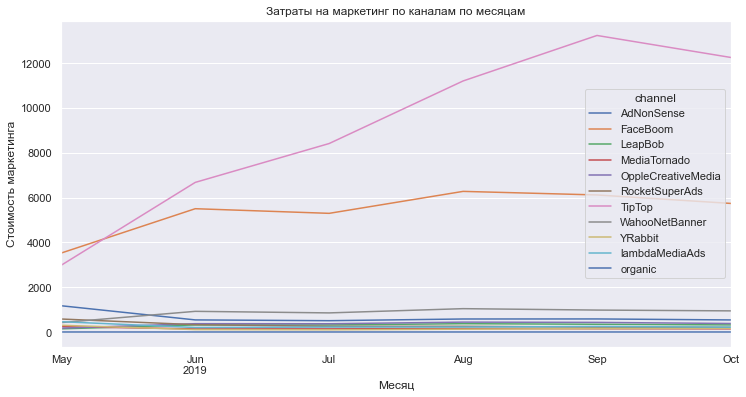

In [26]:
costs_month = profiles.pivot_table(index='month', columns='channel', 
                                   values='acquisition_cost', aggfunc='sum').reset_index()
costs_month.plot(x='month',grid=True, legend=True, figsize=(12, 6))
plt.title('Затраты на маркетинг по каналам по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Стоимость маркетинга')
plt.show()

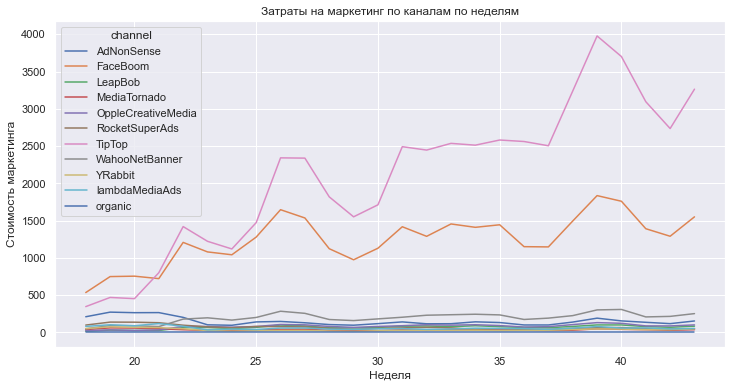

In [27]:
profiles['dt'] = profiles['dt'].astype('datetime64')
profiles['week'] = profiles['dt'].dt.isocalendar().week
costs_month = profiles.pivot_table(index='week', columns='channel', 
                                   values='acquisition_cost', aggfunc='sum').reset_index()
costs_month.plot(x='week',grid=True, legend=True, figsize=(12, 6))
plt.title('Затраты на маркетинг по каналам по неделям')
plt.xlabel('Неделя')
plt.ylabel('Стоимость маркетинга')
plt.show()

__Вывод:__

По двум наиболее затратным источникам привлечения - TipTop и FaceBoom - отмечается постоянный стоимости привлечения. Причем у иных источников такая тенденция отсутствует, расходы на привлечение из месяца в месяц стабильны.


### 4.2  Стоимость привлечения одного пользователя из каждого источника. 

Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. Исключим из выборки пользователей, на привлечение которых не были затрачены средства.

In [28]:
profiles = profiles[profiles['channel'] != 'organic']
print('Cредний CAC на одного пользователя для всего проекта:', profiles['acquisition_cost'].mean())

Cредний CAC на одного пользователя для всего проекта: 1.127481323942928


In [29]:
profiles_cac = (profiles.groupby('channel')
                .agg({'acquisition_cost': 'mean'})
                .sort_values(by ='acquisition_cost', ascending = False))
profiles_cac

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


Так как эта таблица нам больше не понадобится, переделаем ее в сводную таблицу с делением стоимости привлечения пользователей для каждого канала по месяцам и построим график:

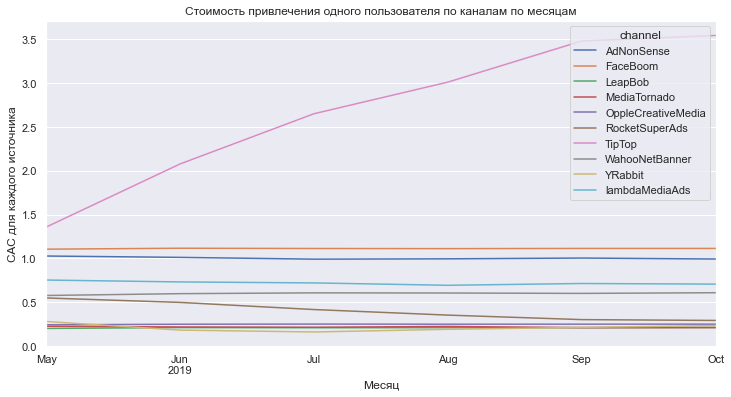

In [30]:
profiles_cac = profiles.pivot_table(index='month', columns='channel', 
                                   values='acquisition_cost', aggfunc='mean').reset_index()
profiles_cac.plot(x='month',grid=True, legend=True, figsize=(12, 6))
plt.title('Стоимость привлечения одного пользователя по каналам по месяцам')
plt.xlabel('Месяц')
plt.ylabel('САС для каждого источника')
plt.show()

__Вывод:__ 

На первом месте по стоимости привлечения одного пользователя - TipTop. Стоимость привлечения в указанном канале более чем в 2 раза превышает стоимость каналов, занявших 2 и 3 место - FaceBoom и  AdNonSense, и растет на протяжении всего периода исследования.

Между тем, напомним, что TipTop и FaceBoom являются лидерами по количеству платящих пользователей. AdNonSense по указанному показателю на 4 месте среди оплачиваемых источников привлечения, в силу чего можно поставить вопрос о целесообразности платы за рекламу в указанном источнике.

Для полноты наших выводов перейдем к оценке окупаемости рекламы.

## Шаг 5. Оценка окупаемости рекламы для привлечения пользователей <a id='fifth_step'></a>

### 5.1 Проанализируем общую окупаемость рекламы

Установим момент анализа и двухнедельный горизонт анализа данных. 

In [31]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI, вызвав функции get_ltv() и plot_ltv_roi().

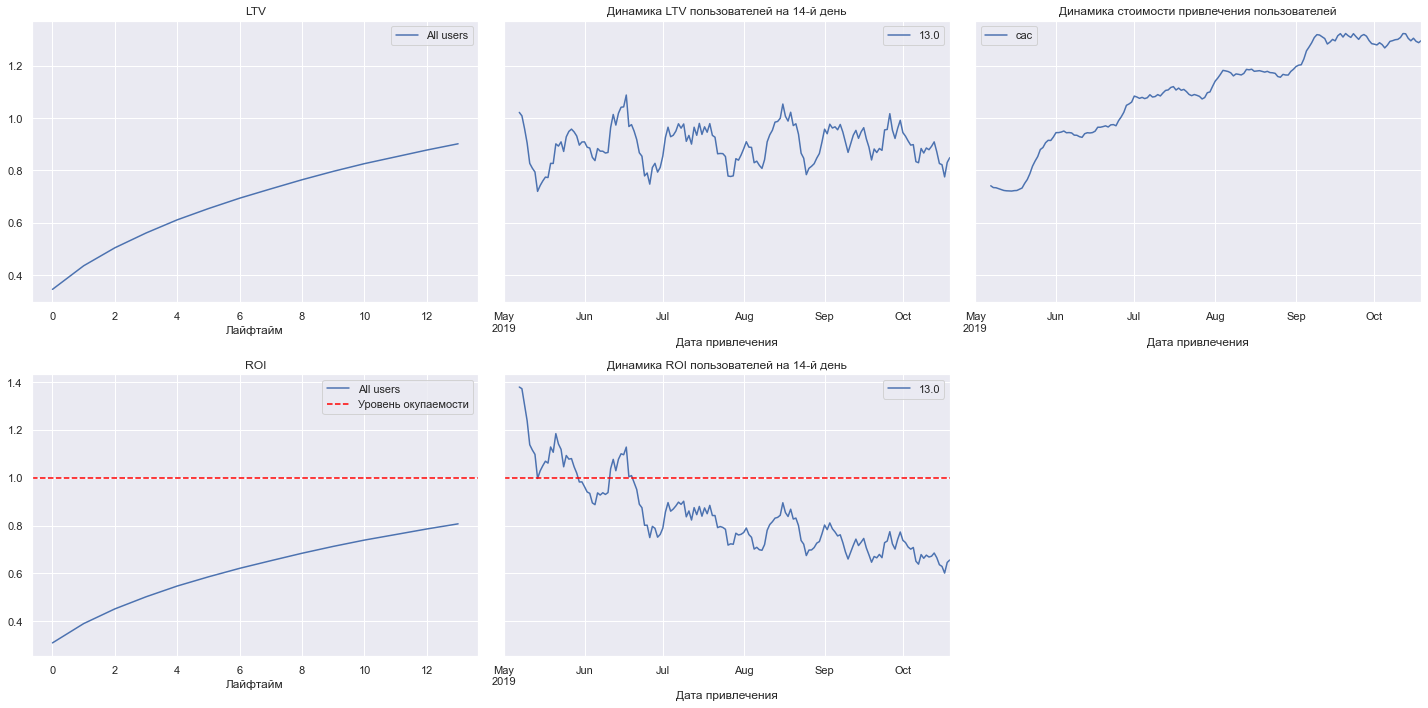

In [32]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:  
- Реклама не окупается. ROI в конце 2-х недель — чуть выше 80%.
- CAC растет на протяжении 5-ти месяцев.
- LTV  достаточно стабилен.

Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### 5.2 Проанализируем окупаемость рекламы с разбивкой по устройствам

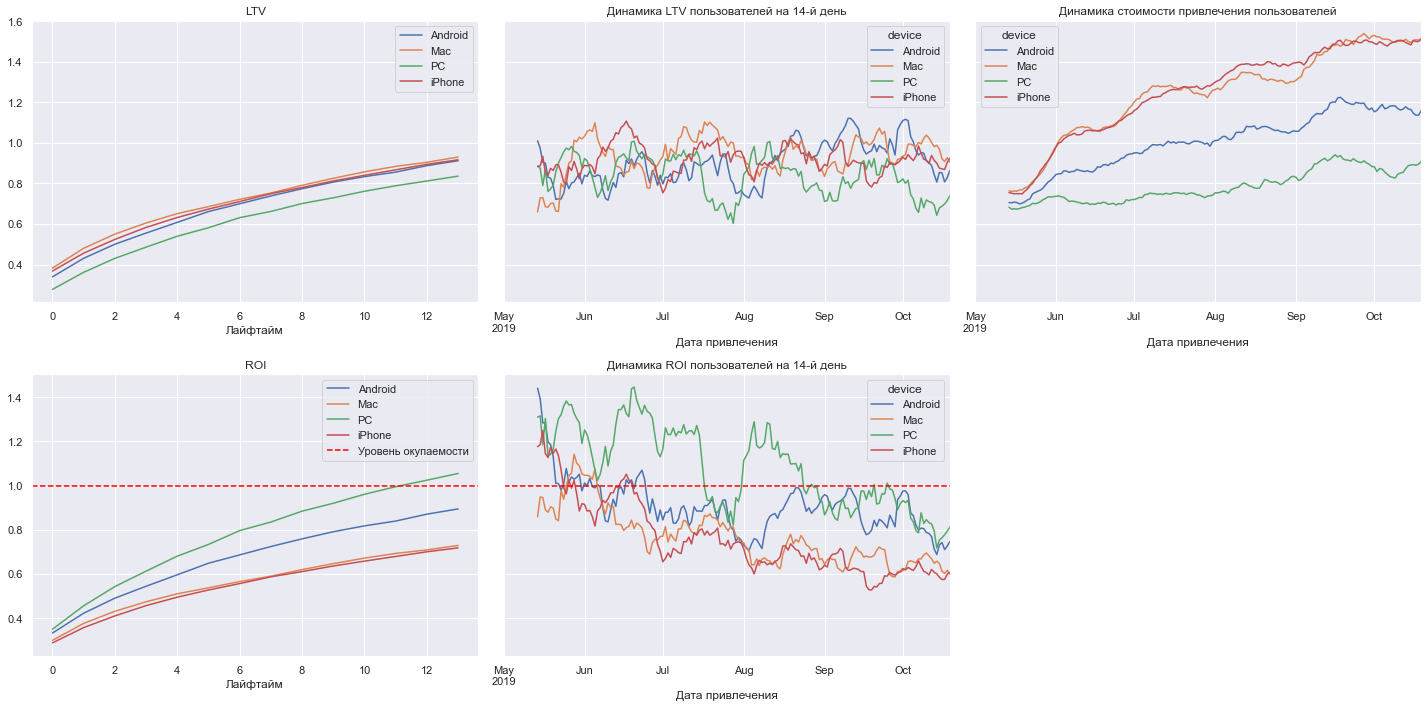

In [33]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Показатель качества пользователей, зашедших с PC стабильно ниже по сравнению с иными устройствами. Между тем, из всех устройств окупается реклама только для PC - это связано с самой низкой стоимостью привлечения пользователей для указанного устройства.

### 5.3 Проанализируем окупаемость рекламы с разбивкой по странам

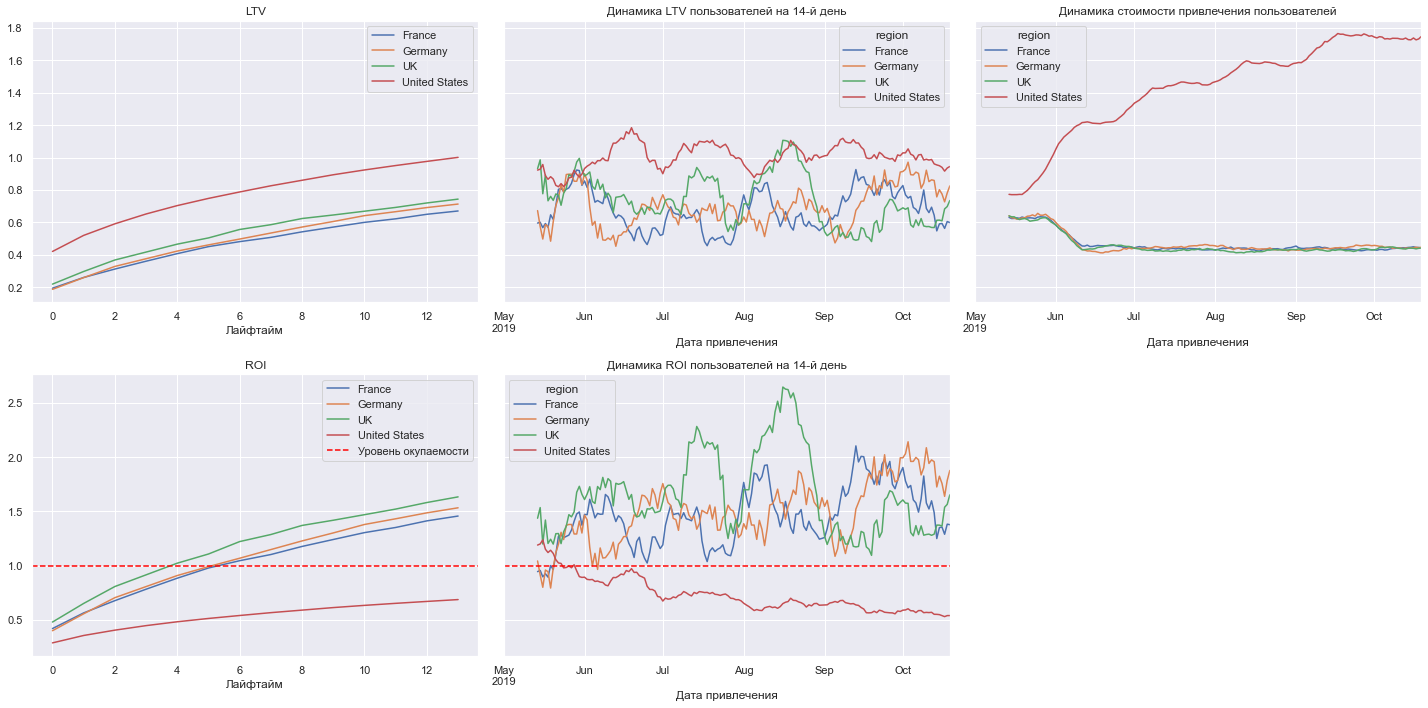

In [34]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Вот что говорят графики:
- Реклама не окупается только в США.
- Стоимость привлечения стабильно низкая для всех стран, кроме США - там наблюдается резкий рост стоимости привлечения, начиная с июня 2019 года.
- LTV стабилен, лучшие показатели - у пользователей из США.

### 5.4 Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

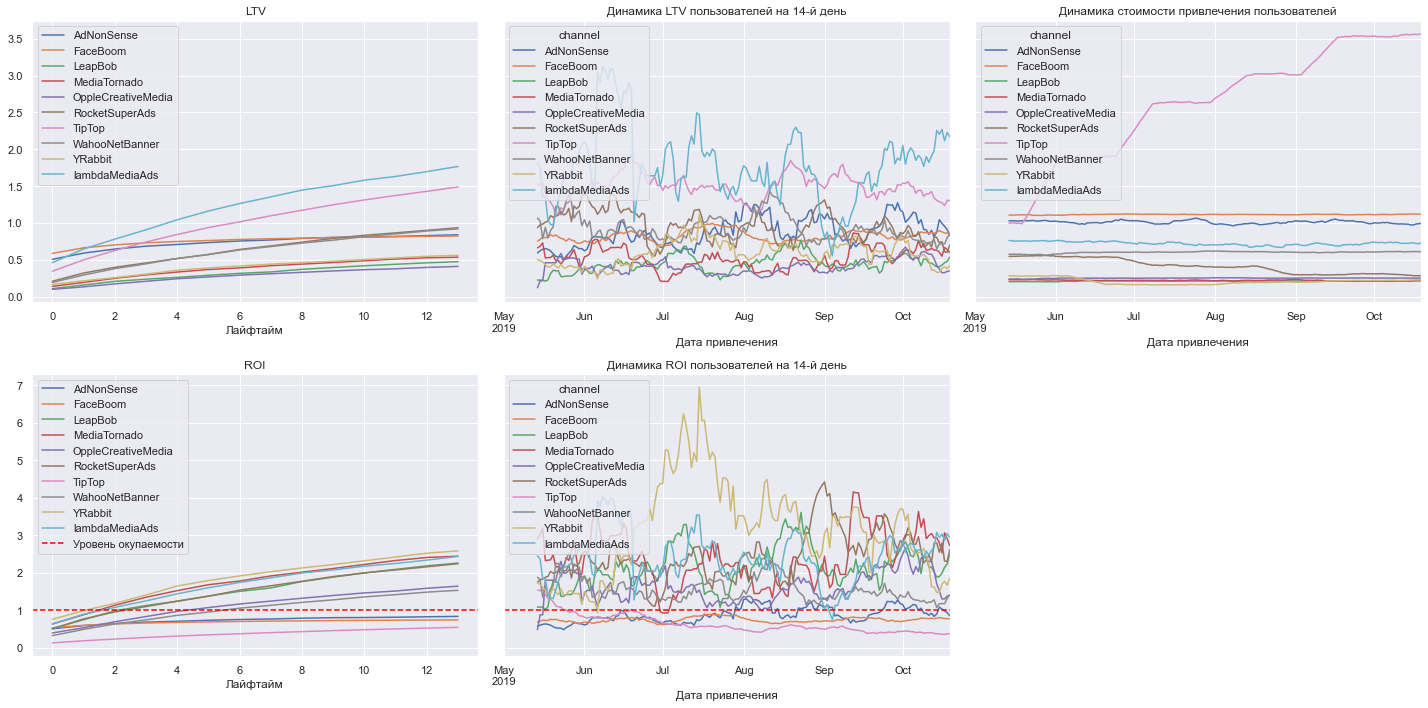

In [35]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

График ROI показывает, что TipTop, FaceBoom  и LeapBoom  - убыточные каналы. И если FaceBoom и LeapBoom показывают низкое качество пользователей, то для TipTop убыточность обусловлена высокой стоимостью привлечения, которую мы определили на предыдущем шаге. 

Несмотря на то, что TipTop лидер по конверсии в платящих пользователей, рост стомости привлечения 1 пользователя не позволяет окупить затраты на рекламу в указанном источнике.

Построим графики с разделением по странам для источников  - TipTop и  FaceBoom.

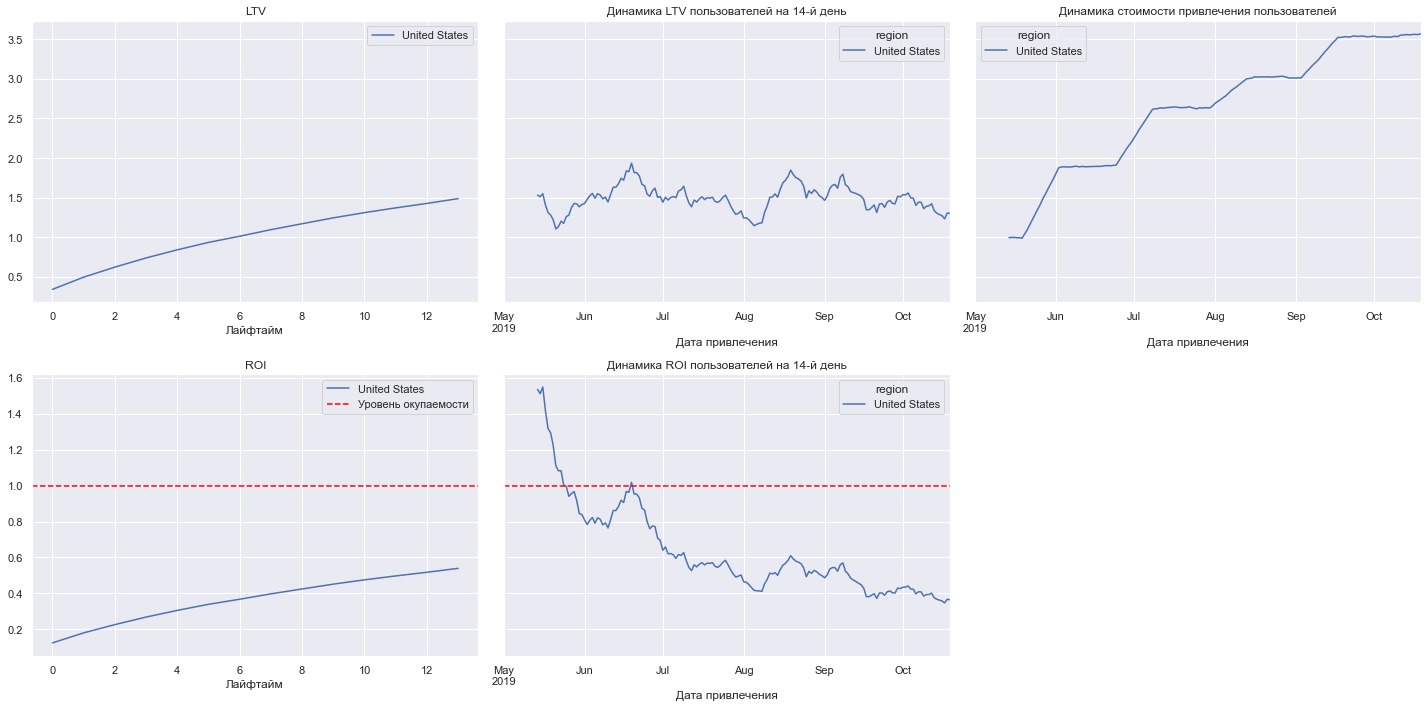

In [36]:
tiptop = profiles[profiles['channel'] == 'TipTop']
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    tiptop, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

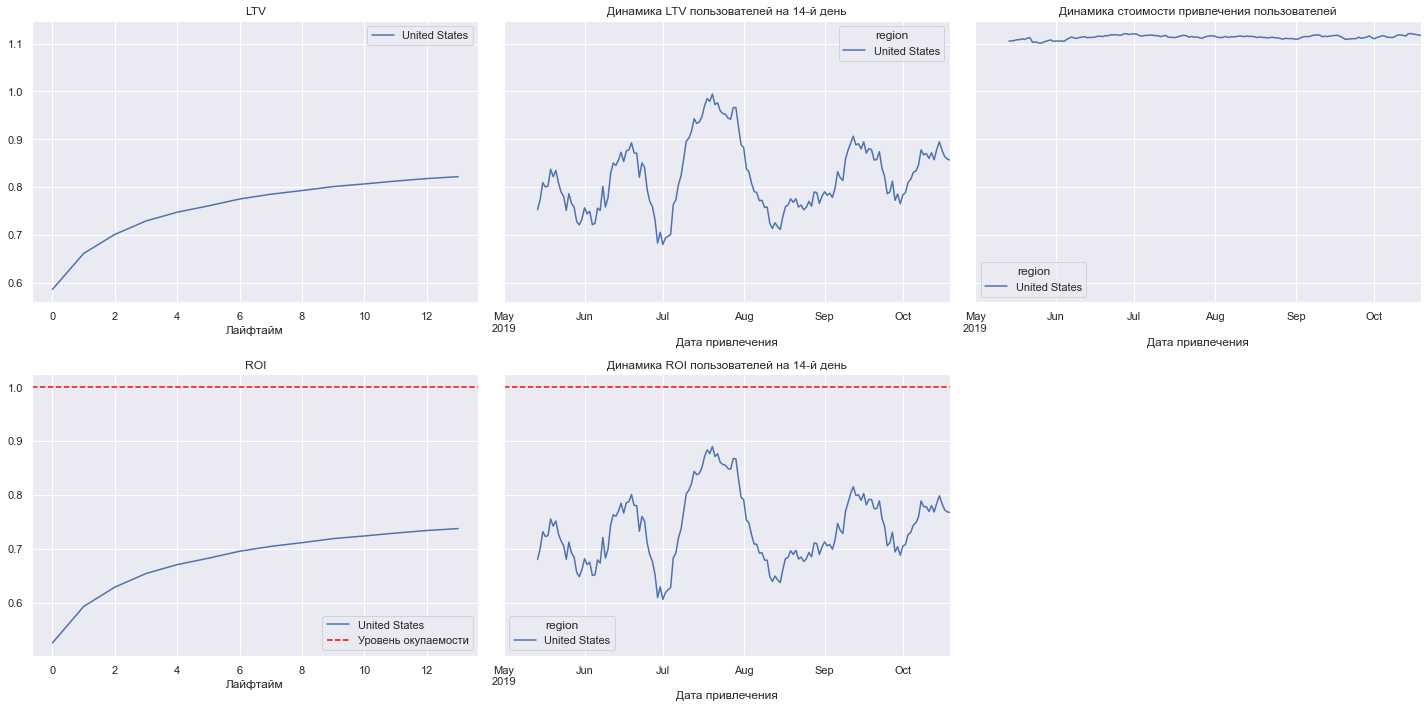

In [37]:
faceboom = profiles[profiles['channel'] == 'FaceBoom']
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    faceboom, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Как и ожидалось, FaceBoom с низким LTV при сравнительно высокой стоимости одного привлеченного пользователя и TipTop с высоким LTV и несоразмерно высокой и постоянно растущей  стоимостью привлечения, не только создают убыток  в рекламном бюджете, 83% которого направлено на указанные каналы, но и влияют на показатели окупаемости США.

### 5.5. Построим и изучиим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

#### Графики конверсии и удержания с разбивкой по устройствам.

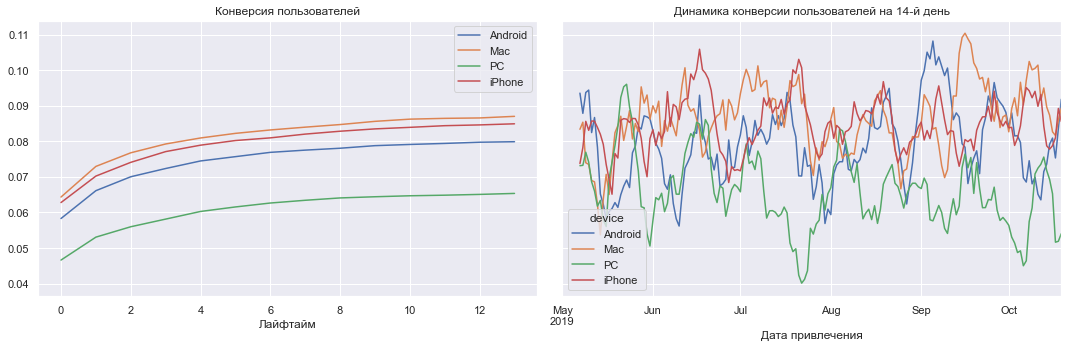

In [38]:
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

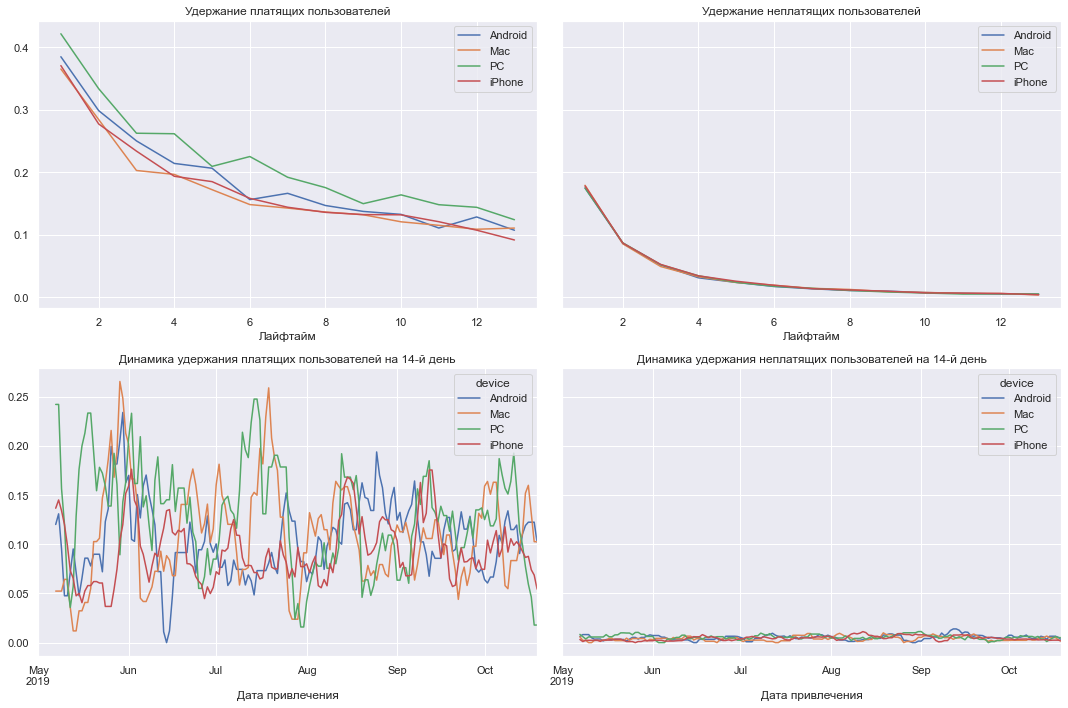

In [39]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Наименьшая конверсия - у пользователей PC. При этом пользователи с этого устройства наиболее надежные. 
Наибольшие показатели конверсии показывают пользователи Mac и iPhone.
Явных аутсайдеров удержания нет, значит, приложение на всех устройствах работает исправно.

#### Графики конверсии и удержания с разбивкой по странам.

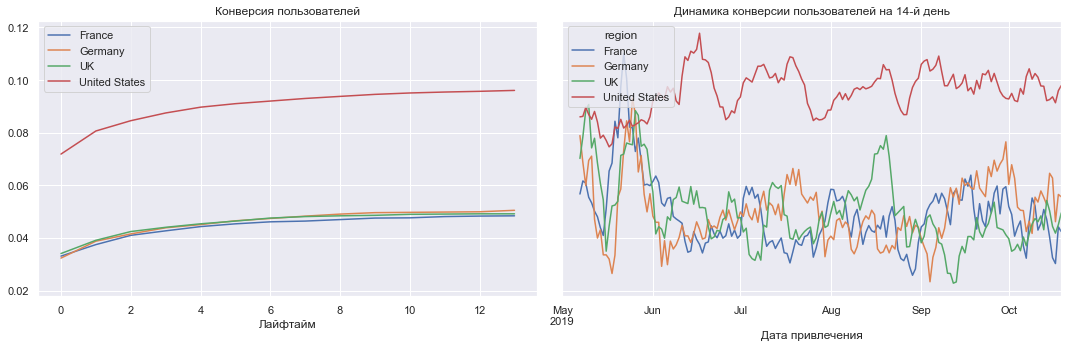

In [40]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

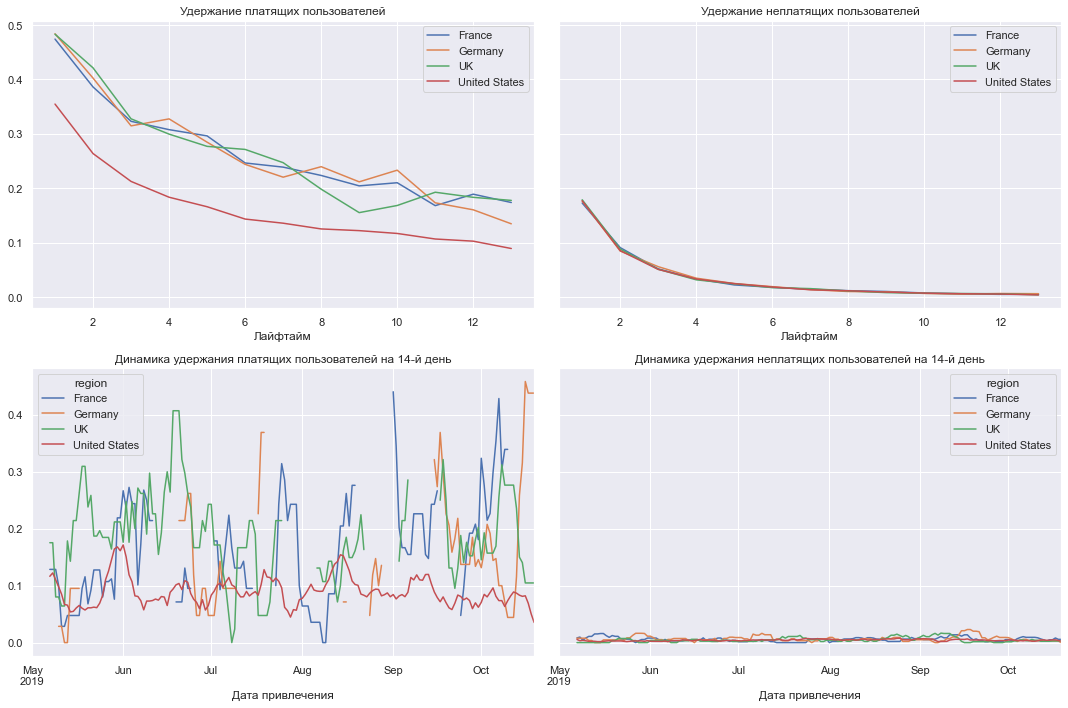

In [41]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Лидер по уровеню конверсии - США, однако указанный регион на последнем месте по уровню удержания платящих пользователей. Следовательно, общее количество привлеченных пользователей и доля платящих пользователей - не показатель эффективности рекламы в указанном регионе из-за высокого отскока платящих пользователей. Необходимо провести более детальное исследование пользовательского опыта покупателей из Америки и определить этап, на котором эти пользователи "отваливаются".

#### Графики конверсии и удержания с разбивкой по каналам

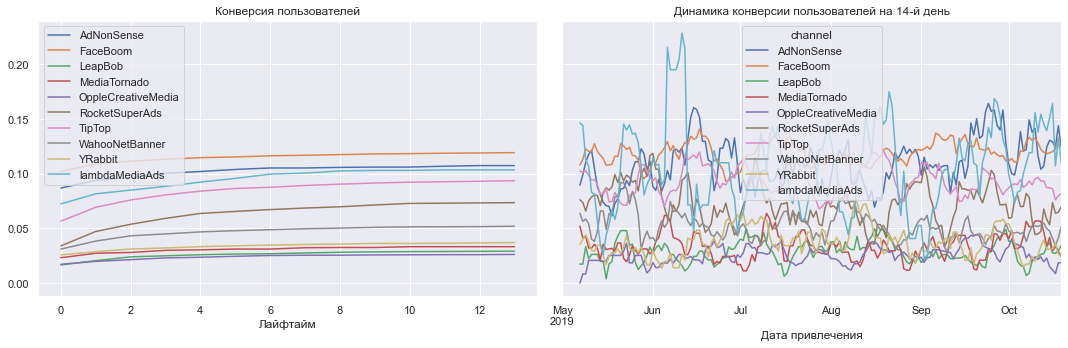

In [42]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

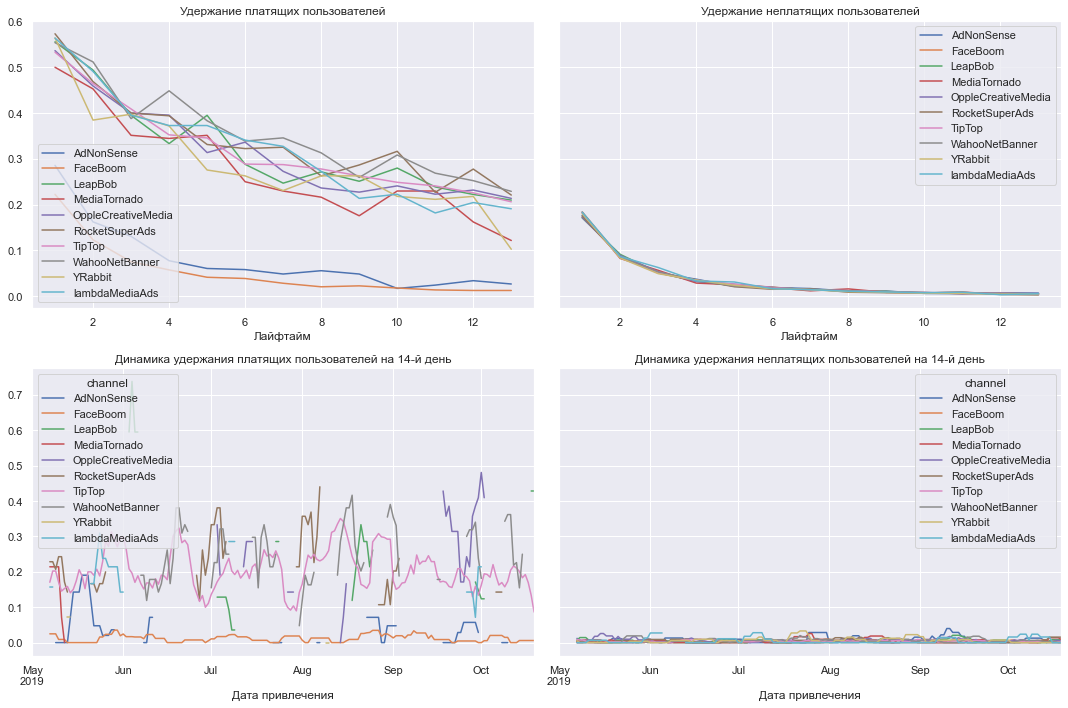

In [43]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

FaceBoom и AdNonSense - источники с высокой конверсией и низким удержанием. Учитывая стоимость привлечения в указанных источниках, возможно следует поставить вопрос о сокращении бюджета на реклаиму в указанных каналах.

__Вывод:__

 - В целом, реклама не окупается. ROI в конце 2-х недель — чуть выше 80%. CAC растет на протяжении 5-ти месяцев.
 
 - Среди стран наименьшей окупаемостью характеризуется реклама  в США - там наблюдается резкий рост стоимости привлечения, начиная с июня 2019 года. Также США - лидер по уровеню конверсии, однако указанный регион на последнем месте по уровню удержания платящих пользователей. Следовательно, общее количество привлеченных пользователей и доля платящих пользователей - не показатель эффективности рекламы в указанном регионе из-за высокого отскока платящих пользователей. 

Необходимо провести более детальное исследование пользовательского опыта покупателей из Америки и определить этап, на котором эти пользователи "отваливаются".
 
 - График ROI показывает, что TipTop, FaceBoom и LeapBoom - убыточные каналы. И если FaceBoom и LeapBoom показывают низкое качество пользователей, то для TipTop убыточность обусловлена высокой стоимостью привлечения, которую мы определили на предыдущем шаге.
 
Несмотря на то, что TipTop лидер по конверсии в платящих пользователей, рост стомости привлечения 1 пользователя не позволяет окупить затраты на рекламу в указанном источнике.  FaceBoom с низким LTV при сравнительно высокой стоимости одного привлеченного пользователя и TipTop с высоким LTV и несоразмерно высокой и постоянно растущей стоимостью привлечения, не только создают убыток в рекламном бюджете 83% которого направлено на указанные каналы, но и влияют на показатели окупаемости США.  FaceBoom и AdNonSense - источники с высокой конверсией и низким удержанием. 

Учитывая стоимость привлечения в TipTop, FaceBoom и LeapBoom и уровень удержащия платящих пользователей в FaceBoom и AdNonSense, возможно следует поставить вопрос о сокращении бюджета на рекламу в указанных каналах и перераспределения средств на более эффективные источники.


- Наименьшая конверсия - у пользователей PC. При этом пользователи с этого устройства наиболее надежные. Наибольшие показатели конверсии показывают пользователи Mac и iPhone. Явных аутсайдеров удержания нет, значит, приложение на всех устройствах работает исправно.

## Шаг 6. Подведем итоги<a id='sixth_step'></a>

Мы собрали общую таблицу профилей пользователей, а также установили минимальную и максимальную даты привлечения. Из полученных данных мы выяснили:
- В нашем приложении зарегистрированы пользователи из США, Великобритании, Франции и Германии. Наибольшее количество платящих пользователей, с большим отрывом, из США. Наименьшее количество пользователей, сделавших покупку - в Германии.
- Для входа в приложение пользователи используют iPhone, Android, Mac, PC. Наибольшее количество покупок совершено с iPhone, на втором месте Android. Несмотря на то, что Mac на 3 месте по количеству платящих пользователей, конверсия пользователя в платящего пользователя в указанном устройстве наибольшая - 6,36%.
- Пользователи были привлечены через следующие каналы: FaceBoom, TipTop, WahooNetBanner, AdNonSense, RocketSuperAds, LeapBob, OppleCreativeMedia, lambdaMediaAds, YRabbit, MediaTornado. Из оплачиваемых каналов привлечения лидерами яляются FaceBoom, TipTop и WahooNetBanner, хотя конверсия в платящих пользователей из канала WahooNetBanner ниже средней по источникам привлечения.
- Наибольшая доля расходов на привлечение относится на TipTop и FaceBoom. В сумме эти два источника забирают 83% рекламного бюджета.
- На первом месте по стоимости привлечения одного пользователя - TipTop. Стоимость привлечения в указанном канале более чем в 2 раза превышает стоимость каналов, занявших 2 и 3 место - FaceBoom и AdNonSense.


__Основные причины неэффективности привлечения пользователей:__
 - Высокая стомость привлечения пользователей в наиболее популярных каналах - TipTop, FaceBoom. Несмотря на то, что TipTop лидер по конверсии в платящих пользователей, рост стомости привлечения 1 пользователя не позволяет окупить затраты на рекламу в указанном источнике. FaceBoom с низким LTV при сравнительно высокой стоимости одного привлеченного пользователя и TipTop с высоким LTV и несоразмерно высокой и постоянно растущей стоимостью привлечения, не только создают убыток в рекламном бюджете 83% которого направлено на указанные каналы, но и влияют на показатели окупаемости США.
 - Низкий уровень удержания пользователей из США, в частности из-за влияния каналов FaceBoom и AdNonSense: компанияя платит за привлечение таких пользователей, однако их жизненный цикл короток, что снижает окупаемость рекламы по всему региону.


__Рекомендации для отдела маркетинга для повышения эффективности.__
 - Следует поставить вопрос о сокращении бюджета на рекламу в TipTop, FaceBoom и перераспределении средств на более эффективные источники.
 - Необходимо провести более детальное исследование пользовательского опыта покупателей из Америки и определить этап, на котором эти пользователи "отваливаются" и причин отскока.
 - В качестве альтренативных каналов для перераспределения рекламного бюджета, сочетающими высокие показатели удержания, конверсии и ROI, можно выбрать RocketSuperAds, lambdaMediaAds и Yrabbit.